In [40]:
%load_ext autoreload
%autoreload 2
    
%matplotlib inline

import numpy as np
from tqdm import tqdm

import pickle


font = {'family' : 'serif',
    'serif': 'helvet',
    'weight' : 'bold',
    'size'   : 31}

matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
def chaotic_dispersion(l):
    return 1./2/l*np.exp(5*l)*(1 -1./4/l*(1-np.exp(-4*l)))

def eoc_dispersion(l,a0):
    return 1./(1+a0)**2/l*(np.exp(5*l)*(1/2+ (16*a0**2+36*a0-25)/200/l ) + 
                          np.exp(l)*(1-4*a0)/8/l +
                          2*a0*(4-a0)/25/l - 2*a0*(1+a0)/5 )


def unbiased_dispersion(K_xy,corr=0):
        
        MC_it = K_xy.shape[1]
        mc_ind = list(range(MC_it))
        corr = int(10*corr)
        
        K = K_xy/K_xy.max(axis=1)[:,None,:]
        
        sum_k = []
        for k in mc_ind:

            ind = mc_ind[:]
            ind.remove(k)

            m1 = np.mean(K[:,ind,corr], axis=1)
            m2 = np.mean(K[:,ind,corr]**2, axis=1)
  
            denom = (MC_it-1)/(MC_it-2)*m1**2 - m2/(MC_it-2)

            nom = K[:,k,corr]**2

            sum_k.append(nom/denom)

        return np.mean(sum_k, axis=0)
    
def bootstrap_var(K_xy, BS_it = 1000,corr=0):
    
    MC_it = K_xy.shape[1]
    mc_ind = list(range(MC_it))
    corr = int(10*corr)
        
    K = K_xy/K_xy.max(axis=1)[:,None,:]
    
    r_samples = []

    for i in range(BS_it):

        sum_k = []

        ind_bs_1 = np.random.choice(mc_ind, MC_it, replace = True)
        ind_bs_2 = np.random.choice(mc_ind, MC_it, replace = True)

        denom = np.mean(K[:,ind_bs_1,corr], axis=1)**2
        nom = np.mean(K[:,ind_bs_2,corr]**2,axis=1)
        r_samples.append(nom/denom)
        
    return np.std(r_samples,axis=0)

In [110]:
def flatten(t):
    return [item for sublist in t for item in sublist]

def E_w(a,n):
    L = len(n)-1
    return a**(L-1)*sum([n[l-1]/n[0] for l in range(1,L+1)])

def E_b(a,n):
    L = len(n)-1
    return sum([a**(L-l) for l in range(1,L+1)])

def E_w2(a,n):
    L = len(n)-1
   
    x = 1+5/n
    y = 1+1/n
    
    diag = [a**(2*L-2)*(n[l-1]/n[0])**2*np.prod(x[l:-1])*np.prod(x[1:l]) for l in range(1,L+1)]

    
    non_diag = [[a**(2*L-2)*n[l2-1]*n[l1-1]/n[0]**2
                           *np.prod(x[l2:-1])*np.prod(y[l1:l2])*np.prod(x[1:l1]) 
                           for l2 in range(l1+1,L+1)] 
                         for l1 in range(1,L+1)]
    
    return sum(diag) + 2*sum(flatten(non_diag))



def E_b2(a,n):
    L = len(n)-1
    x = 1+5/n
    
    s1 = [a**(2*(L-l))*np.prod(x[l:-1]) for l in range(1,L+1)]
    s2 = [[a**(2*L-l1-l2)*np.prod(x[l2:-1]) for l2 in range(l1+1,L+1)] for l1 in range(1,L+1)]
    
    return sum(s1) + 2*sum(flatten(s2))

def E_wb(a,n):
    L = len(n)-1
    x = 1+5/n
    y = 1+1/n
    
    s1 = [a**(2*L-l-1)*n[l-1]/n[0]*np.prod(x[l:-1]) for l in range(1,L+1)]
    s2 = [[a**(2*L-l1-1)*n[l2-1]/n[0]*np.prod(y[l1:l2])*np.prod(x[l2:-1]) for l2 in range(l1+1,L+1)] 
          for l1 in range(1,L+1)]
    s3 = [[a**(2*L-l2-1)*n[l1-1]/n[0]*np.prod(x[l2:-1]) for l2 in range(l1+1,L+1)] 
          for l1 in range(1,L+1)]
    
    return sum(s1) + sum(flatten(s2)) + sum(flatten(s3))


def E_t(a,n):
    return E_w(a,n) + E_b(a,n)

def E_t2(a,n):
    return E_w2(a,n) + E_b2(a,n) + 2*E_wb(a,n)

def g(x):
    return (np.sqrt(1-x**2) + x*np.pi/2 + x*np.arcsin(x))/np.pi

def f(x):
    return (np.pi/2 + np.arcsin(x))/np.pi

def compose(f, n):
    def fn(x):
        for _ in range(n):
            x = f(x)
        return x
    return fn

def ordered_ratio(a,r0,n):
    
    L = len(n)-1
    
    r_x = np.array([compose(g,k)(r0) for k in range(0,L)])
    r_d = np.array([f(r_x[k]) for k in range(0,L)])
    
    b = [a**(L-l)*np.prod(r_d[l:]) for l in range(1,L+1)]
    
    return sum(b)/E_b(a,n)

## Figure 1: NTK dispersion in the infinite-depth-and-width limit

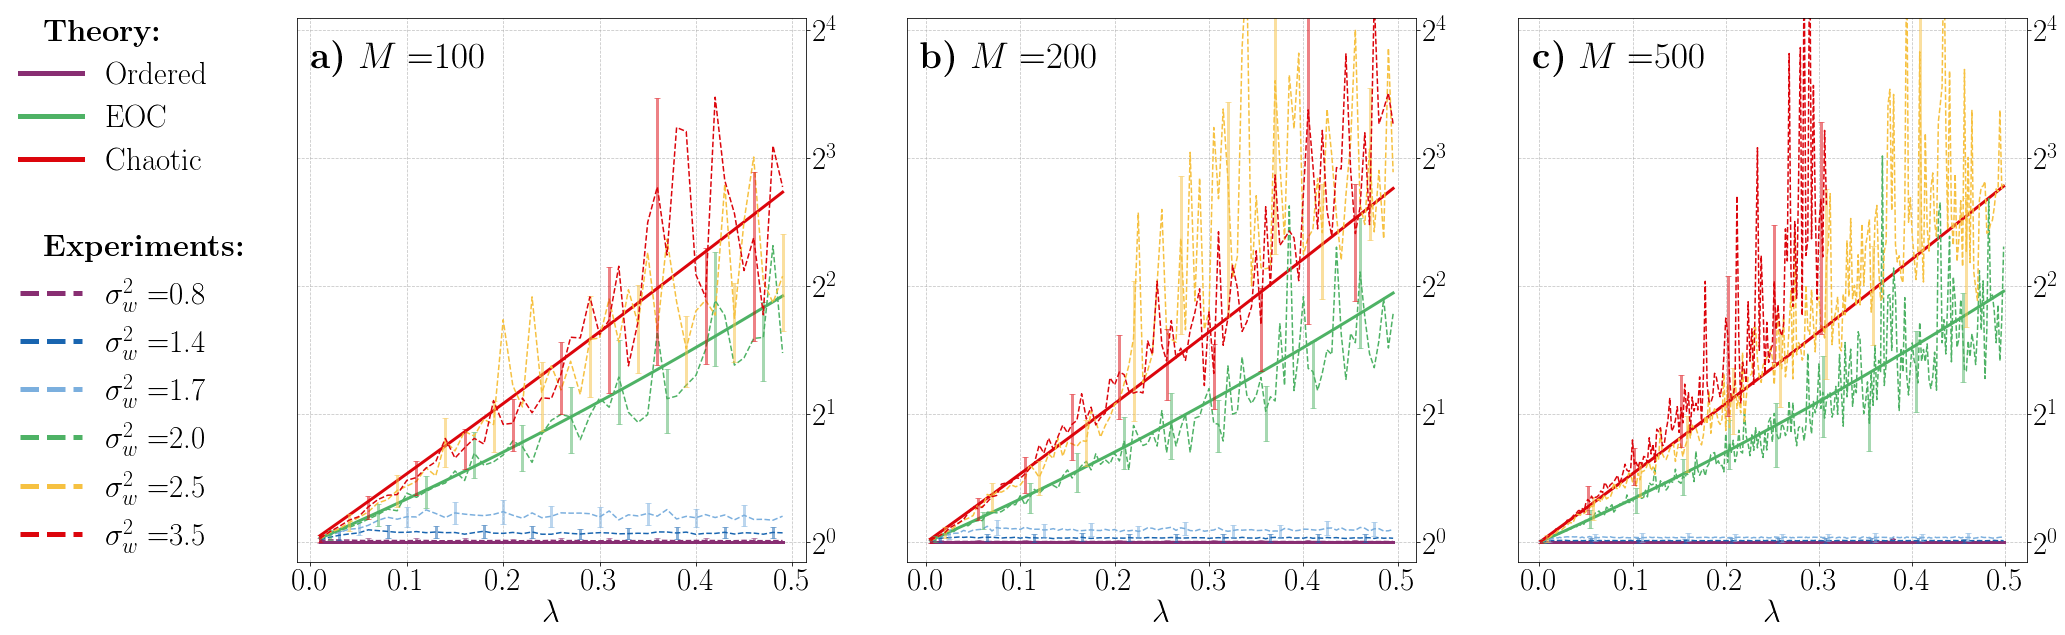

In [101]:
fig, axs = plt.subplots(1,3, figsize=(31,10))

Ms = [100, 200, 500]
a0 = 1.

corr = 0

colors = np.array(['#882e72','#1965b0','#7bafde','#4eb265','#f6c141','#dc050c'])
var_w_s = np.array([0.8,1.4,1.7,2.0,2.5,3.5])
subfig_names = ['a','b','c']

for ax, M, subfig in zip(axs,Ms,subfig_names):
    
    L = int(M/2)
    n0 = int(a0*M)
    
    ax.plot(l,[1]*len(l),color=colors[0],linewidth=3, label='Ordered')

    eoc = eoc_dispersion(l,a0)
    ax.plot(l,eoc,color=colors[np.argwhere(var_w_s==2.0)].item(),linewidth=3,label='EOC')

    chaotic = chaotic_dispersion(l)
    ax.plot(l,chaotic,color=colors[-1],linewidth=3, label='Chaotic')


    for j,(var_w,color) in enumerate(zip(var_w_s,colors)):

        K_xy = pickle.load(open(path+'K_xy_w'+str(int(var_w*10))+'M'+str(M)+'n'+str(n0), 'rb') )
        l = np.array(range(1,L))/M
        
        nans = np.vstack((np.argwhere(np.isnan(K_xy)),np.argwhere(np.isinf(K_xy))))
    
        if nans.size != 0:   
            max_layer = nans[:,0].min()
            K_xy = K_xy[:max_layer,:,:]
            l = l[:max_layer]
    
        r_mean = unbiased_dispersion(K_xy)
        r_std = bootstrap_var(K_xy)

        ax.plot(l,r_mean, ls='--', label="$\sigma_w^2= $"+str(var_w), color=color)
        ax.errorbar(x = l, y = r_mean, yerr=r_std, fmt='None', color=color,
                 ecolor=color, elinewidth=3, capsize=3, errorevery=((2*j)%5,5*int(M/100)), alpha=0.5)
  
    
    ax.set_yscale('log',base=2)
    ax.set_ylim([0.9,17])
    ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5])
    ax.tick_params(axis='y', which='both', labelleft=False, labelright=True, left=False, right=True)  

    ax.set_xlabel('$\lambda$')
    ax.set_title(r"\textbf{"+subfig +")} $M =$"+str(M), y=0.9, x=0.2)

    ax.grid(alpha=0.7,ls='--')
    
    
(lines, labels) = axs[0].get_legend_handles_labels()
lines.insert(0,plt.Line2D([0],[0], linestyle='None', marker='None'))
labels.insert(0, r'\textbf{Theory:}')

ind_exp_legend = -len(var_w_s)
lines.insert(ind_exp_legend,plt.Line2D([0],[0], linestyle='None', marker='None'))
labels.insert(ind_exp_legend, '')
lines.insert(ind_exp_legend,plt.Line2D([0],[0], linestyle='None', marker='None'))
labels.insert(ind_exp_legend, r'\textbf{Experiments:}')
    
leg = axs[0].legend(lines,labels, bbox_to_anchor=(-0.6,1.05), loc='upper left', ncol=1, frameon=False) 

for line in leg.get_lines():
    line.set_linewidth(5)

for vpack in leg._legend_handle_box.get_children()[:1]:
    hs = vpack.get_children()[:1] + vpack.get_children()[ind_exp_legend-1:ind_exp_legend]
    for hpack in hs:
        hpack.get_children()[0].set_width(0)


## Figure 2: NTK dispersion near EOC (finite-width effects)

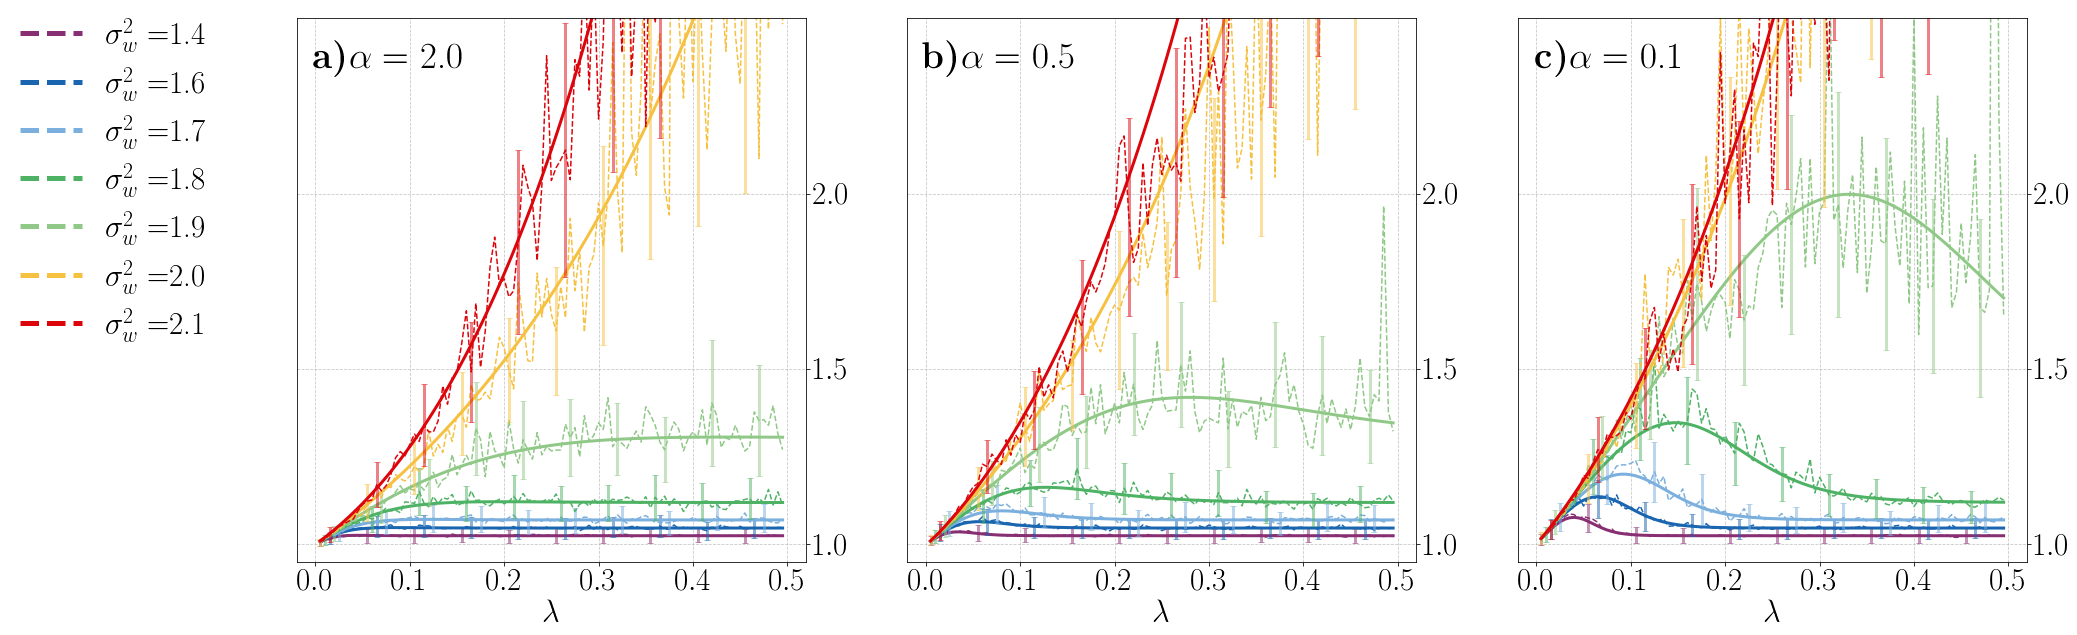

In [37]:
fig, axs = plt.subplots(1,3, figsize=(31,10))


M = 200
a0s = [2.0,0.5,0.1]

corr = 0

L_max = int(M/2)

colors = np.array(['#882e72','#1965b0','#7bafde','#4eb265','#90c987','#f6c141','#dc050c'])
var_w_s = np.array([1.4,1.6,1.7,1.8,1.9,2.0,2.1])
subfig_names = ['a','b','c']

for ax, a0, subfig in zip(axs,a0s,subfig_names):
    
    L = int(M/2)
    n0 = int(a0*M)
    
    
    for j,(var_w,color) in enumerate(zip(var_w_s,colors)):
        
        K_xy = pickle.load(open(path+'K_xy_w'+str(int(var_w*10))+'M'+str(M)+'n'+str(n0), 'rb') )
        l = np.array(range(1,L))/M
        
        nans = np.vstack((np.argwhere(np.isnan(K_xy)),np.argwhere(np.isinf(K_xy))))
    
        if nans.size != 0:   
            max_layer = nans[:,0].min()
            K_xy = K_xy[:max_layer,:,:]
            l = l[:max_layer]
    
        r_mean = unbiased_dispersion(K_xy)
        r_std = bootstrap_var(K_xy)

        ax.plot(l,r_mean, ls='--', label="$\sigma_w^2= $"+str(var_w), color=color)
        ax.errorbar(x = l, y = r_mean, yerr=r_std, fmt='None', color=color,
                 ecolor=color, elinewidth=3, capsize=3, errorevery=((2*j)%5,5*int(M/100)), alpha=0.5)
        
        
        a=var_w/2.
        theory = [E_t2(a,np.array([n0]+ i*[M] + [1]))/E_t(a,np.array([n0]+ i*[M] + [1]))**2 
                for i in range(1,L)]
    
        ax.plot(l,theory, linewidth=3, color=color)

    
    ax.set_ylim([0.95,2.5])
    ax.set_yticks([1,1.5,2.0])
    ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5])
    ax.tick_params(axis='y', which='both', labelleft=False, labelright=True, left=False, right=True)   

    ax.set_xlabel('$\lambda$')
    ax.set_title("$\ \\textbf{"+subfig+")}"+"\\alpha = \ $"+str(a0), y=0.9, x=0.18)

    ax.grid(alpha=0.7,ls='--')
    
    
leg = axs[0].legend(bbox_to_anchor=(-0.6,1.05), loc='upper left', ncol=1, frameon=False) 

for line in leg.get_lines():
    line.set_linewidth(5)


## Figure 3: Ratio of non-diagonal and diagonal elements of the NTK

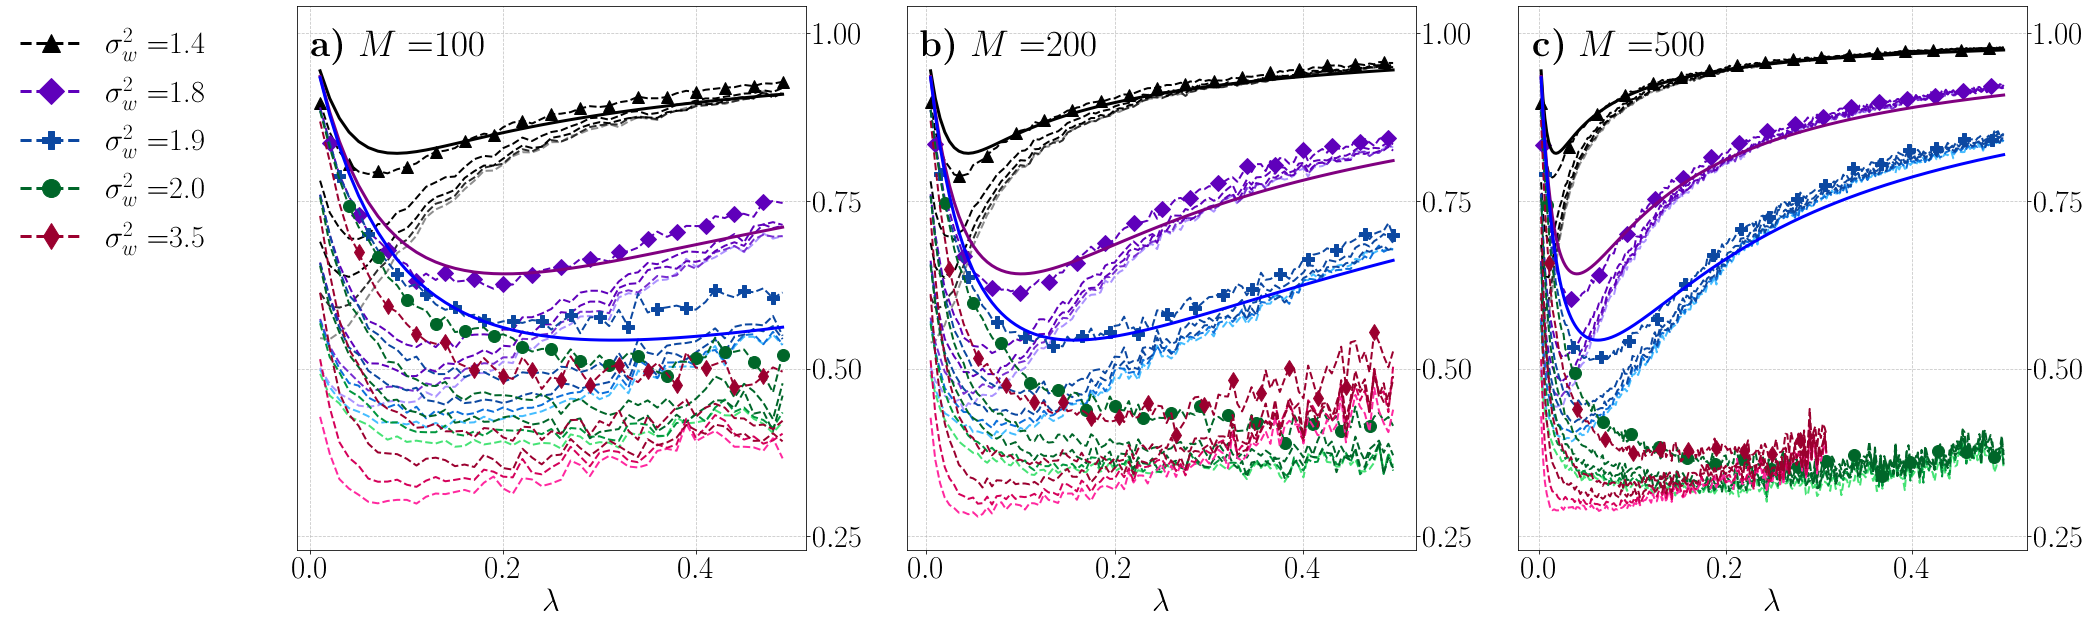

In [134]:
fig, axs = plt.subplots(1,3,figsize=(31,10))


Ms = [100,200,500]
var_w_s = [1.4,1.8,1.9,2.0,3.5]
cmaps = ["Greys","Purples","Blues","Greens","PuRd"]
colors = ['black', 'purple', 'blue']
markers = ['^',"D",'P','o','d']

subfig_names = ['a','b','c']

for M,ax,subfig in zip(Ms,axs,subfig_names):

    L = int(M/2)
    n0 = M

    for j,(var_w,cmap_name,m) in enumerate(zip(var_w_s,cmaps,markers)):
       
        K_xy = pickle.load(open(path+'K_xy_w'+str(int(var_w*10))+'M'+str(M)+'n'+str(n0), 'rb') )
        l = np.array(range(1,L))/M
        MC_it = K_xy.shape[1]

        nans = np.vstack((np.argwhere(np.isnan(K_xy)),np.argwhere(np.isinf(K_xy))))
        
        if nans.size != 0:   
            max_layer = nans[:,0].min()
            K_xy = K_xy[:max_layer,:,:]
            l = l[:max_layer]
            
        K_xy = K_xy/K_xy.max()

        diag = np.mean(K_xy[:,:,0],axis=1)
        
        for i,r0 in enumerate([0.1,0.3,0.5,0.7,0.9]):
            color = tuple(np.minimum(1,np.array(cm.get_cmap(cmap_name)(0.5+0.2*(i+1)))*1.5))
            non_diag = np.mean(K_xy[:,:,round((1-r0)*10)],axis=1)
            
            if i==4:
                ax.plot(l, non_diag/diag, ls='--', linewidth=2,
                     marker = m, markevery=(j,int(M/100)*3), markersize=12,
                     label='$\sigma_w^2=$'+str(var_w), color=color)
            else:
                ax.plot(l, non_diag/diag, ls='--', linewidth=2,
                     label='$\sigma_w^2=$'+str(var_w), color=color)
        
        
        ax.grid(alpha=0.7,ls='--')
        ax.set_ylim([0.23,1.04])
        ax.set_xlabel('$\lambda$')
        
        ax.set_yticks([0.25,0.5,0.75,1.])
        ax.yaxis.tick_right()
        
        ax.set_title(r"$\textbf{"+subfig+")}\ M =$"+str(M), y=0.9, x=0.2)
        

    L = int(M/2)
    n0 = M
    l = np.array(range(1,L))/M

    for var_w, color in zip([1.4,1.8,1.9],colors):
        a = var_w/2.
        ax.plot(l, [ordered_ratio(a,0.9,[n0]+i*[M]+[1]) for i in range(1,L)],
                     linestyle='-', linewidth=3, color=color)


(lines, labels) = axs[0].get_legend_handles_labels()
lines = [lines[5*(k+1)-1] for k in range(len(var_w_s))]
labels = [labels[5*(k+1)-1] for k in range(len(var_w_s))]


leg = axs[0].legend(lines,labels, bbox_to_anchor=(-0.6,1.01), 
                   loc='upper left', ncol=1, frameon=False, markerscale=1.5) 
leg.get_frame().set_alpha(0.5)

for line in leg.get_lines():
    line.set_linewidth(3) 

## Figure 5: Effects of the architecture on the NTK dispersion 

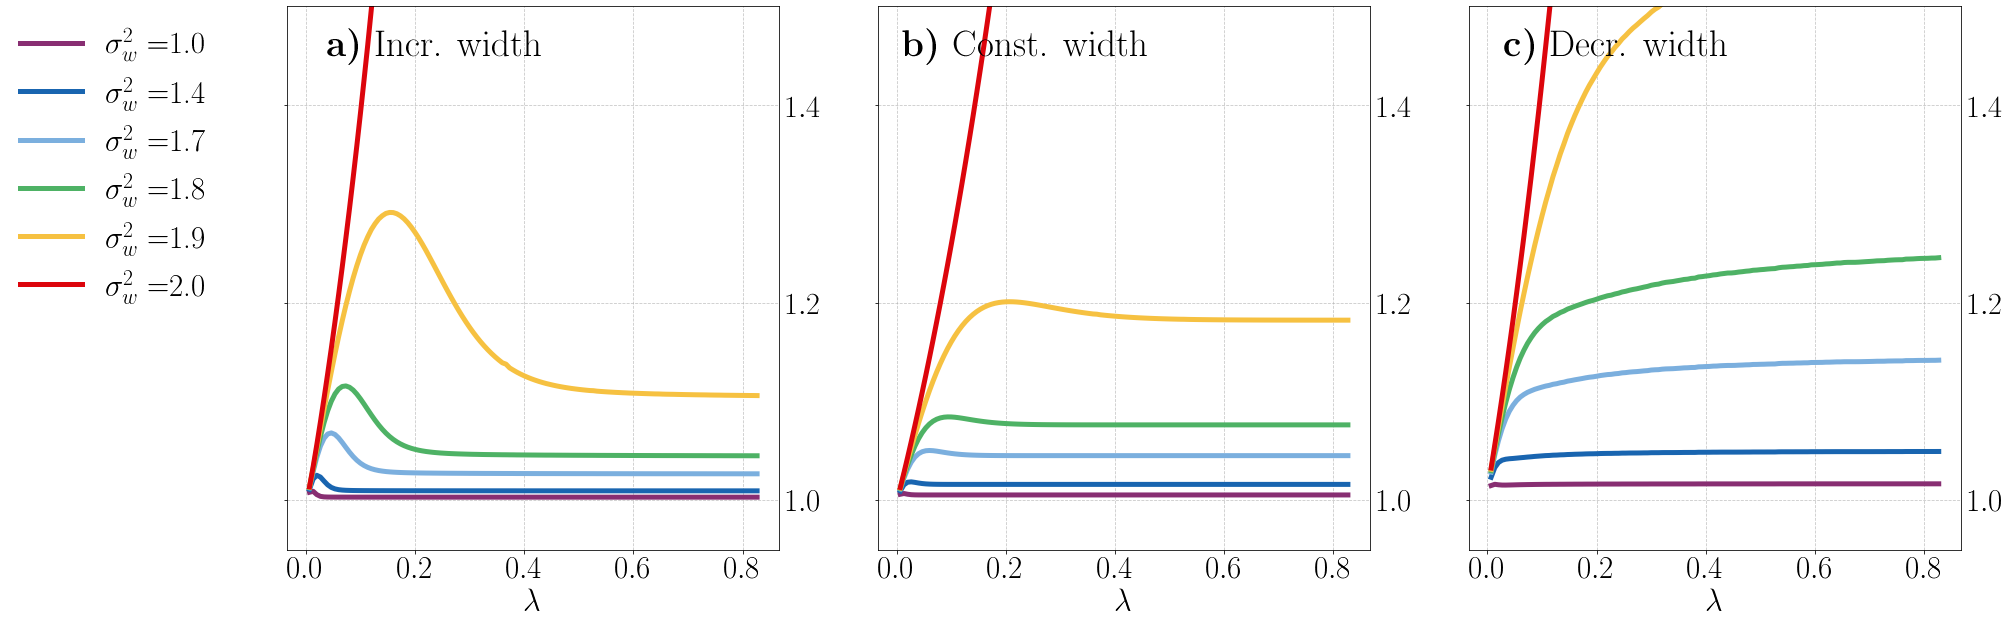

In [129]:
fig, axs = plt.subplots(1,3,figsize=(30,10))

M=500
n0=100

var_w_s = [1.0,1.4,1.7,1.8,1.9,2.0]

L = int(M/2)

titles = [r"$\textbf{a)}$ Incr. width",
          r"$\textbf{b)}$ Const. width",
          r"$\textbf{c)}$ Decr. width"]

colors = ['#882e72','#1965b0','#7bafde','#4eb265','#f6c141','#dc050c']

for j,(var_w,color) in enumerate(zip(var_w_s,colors)):

    a=var_w/2.
    l = np.array(range(2,L,2))/(M+n0)*2
    
    r = []
    for l_ in (l*(M+n0)/2).astype(int):
        n = [n0] + [round(n0 + (M-n0)/l_*i) for i in range(1,l_+1)] + [1] #incr

        n = np.array(n)
        r.append(E_t2(a,n)/E_t(a,n)**2)

    axs[0].plot(l,r, ls='-', linewidth=5, label="$\sigma_w^2= $"+str(var_w), color=color)

    
    r = []
    for l_ in (l*(M+n0)/2).astype(int):
        n = [int(M+n0)/2]*(l_+1) + [1]

        n = np.array(n)
        r.append(E_t2(a,n)/E_t(a,n)**2)

    axs[1].plot(l,r, ls='-', linewidth=5, label="$\sigma_w^2= $"+str(var_w), color=color)
    
    r = []
    for l_ in (l*(M+n0)/2).astype(int):
        n = [M] + [round(M + (n0-M)/l_*i) for i in range(1,l_+1)] + [1]

        n = np.array(n)
        r.append(E_t2(a,n)/E_t(a,n)**2)

    axs[2].plot(l,r, ls='-', linewidth=5, label="$\sigma_w^2= $"+str(var_w), color=color)



for ax,title in zip(axs,titles):
    ax.set_ylim([0.95,1.5])
    ax.grid(alpha=0.7,ls='--')
    ax.set_xlabel('$\lambda$')
    ax.set_title(title, y=0.9, x=0.3)
    ax.set_yticks([1.0,1.2,1.4])


    ax.tick_params(axis='y', which='both', labelleft=False, labelright=True)   


leg = axs[0].legend(bbox_to_anchor=(-0.6,1.01), loc='upper left', ncol=1, frameon=False) 

leg.get_frame().set_alpha(0.5)

for line in leg.get_lines():
    line.set_linewidth(5)

## Figure 6: Dispersion of the non-diagonal NTK elements 

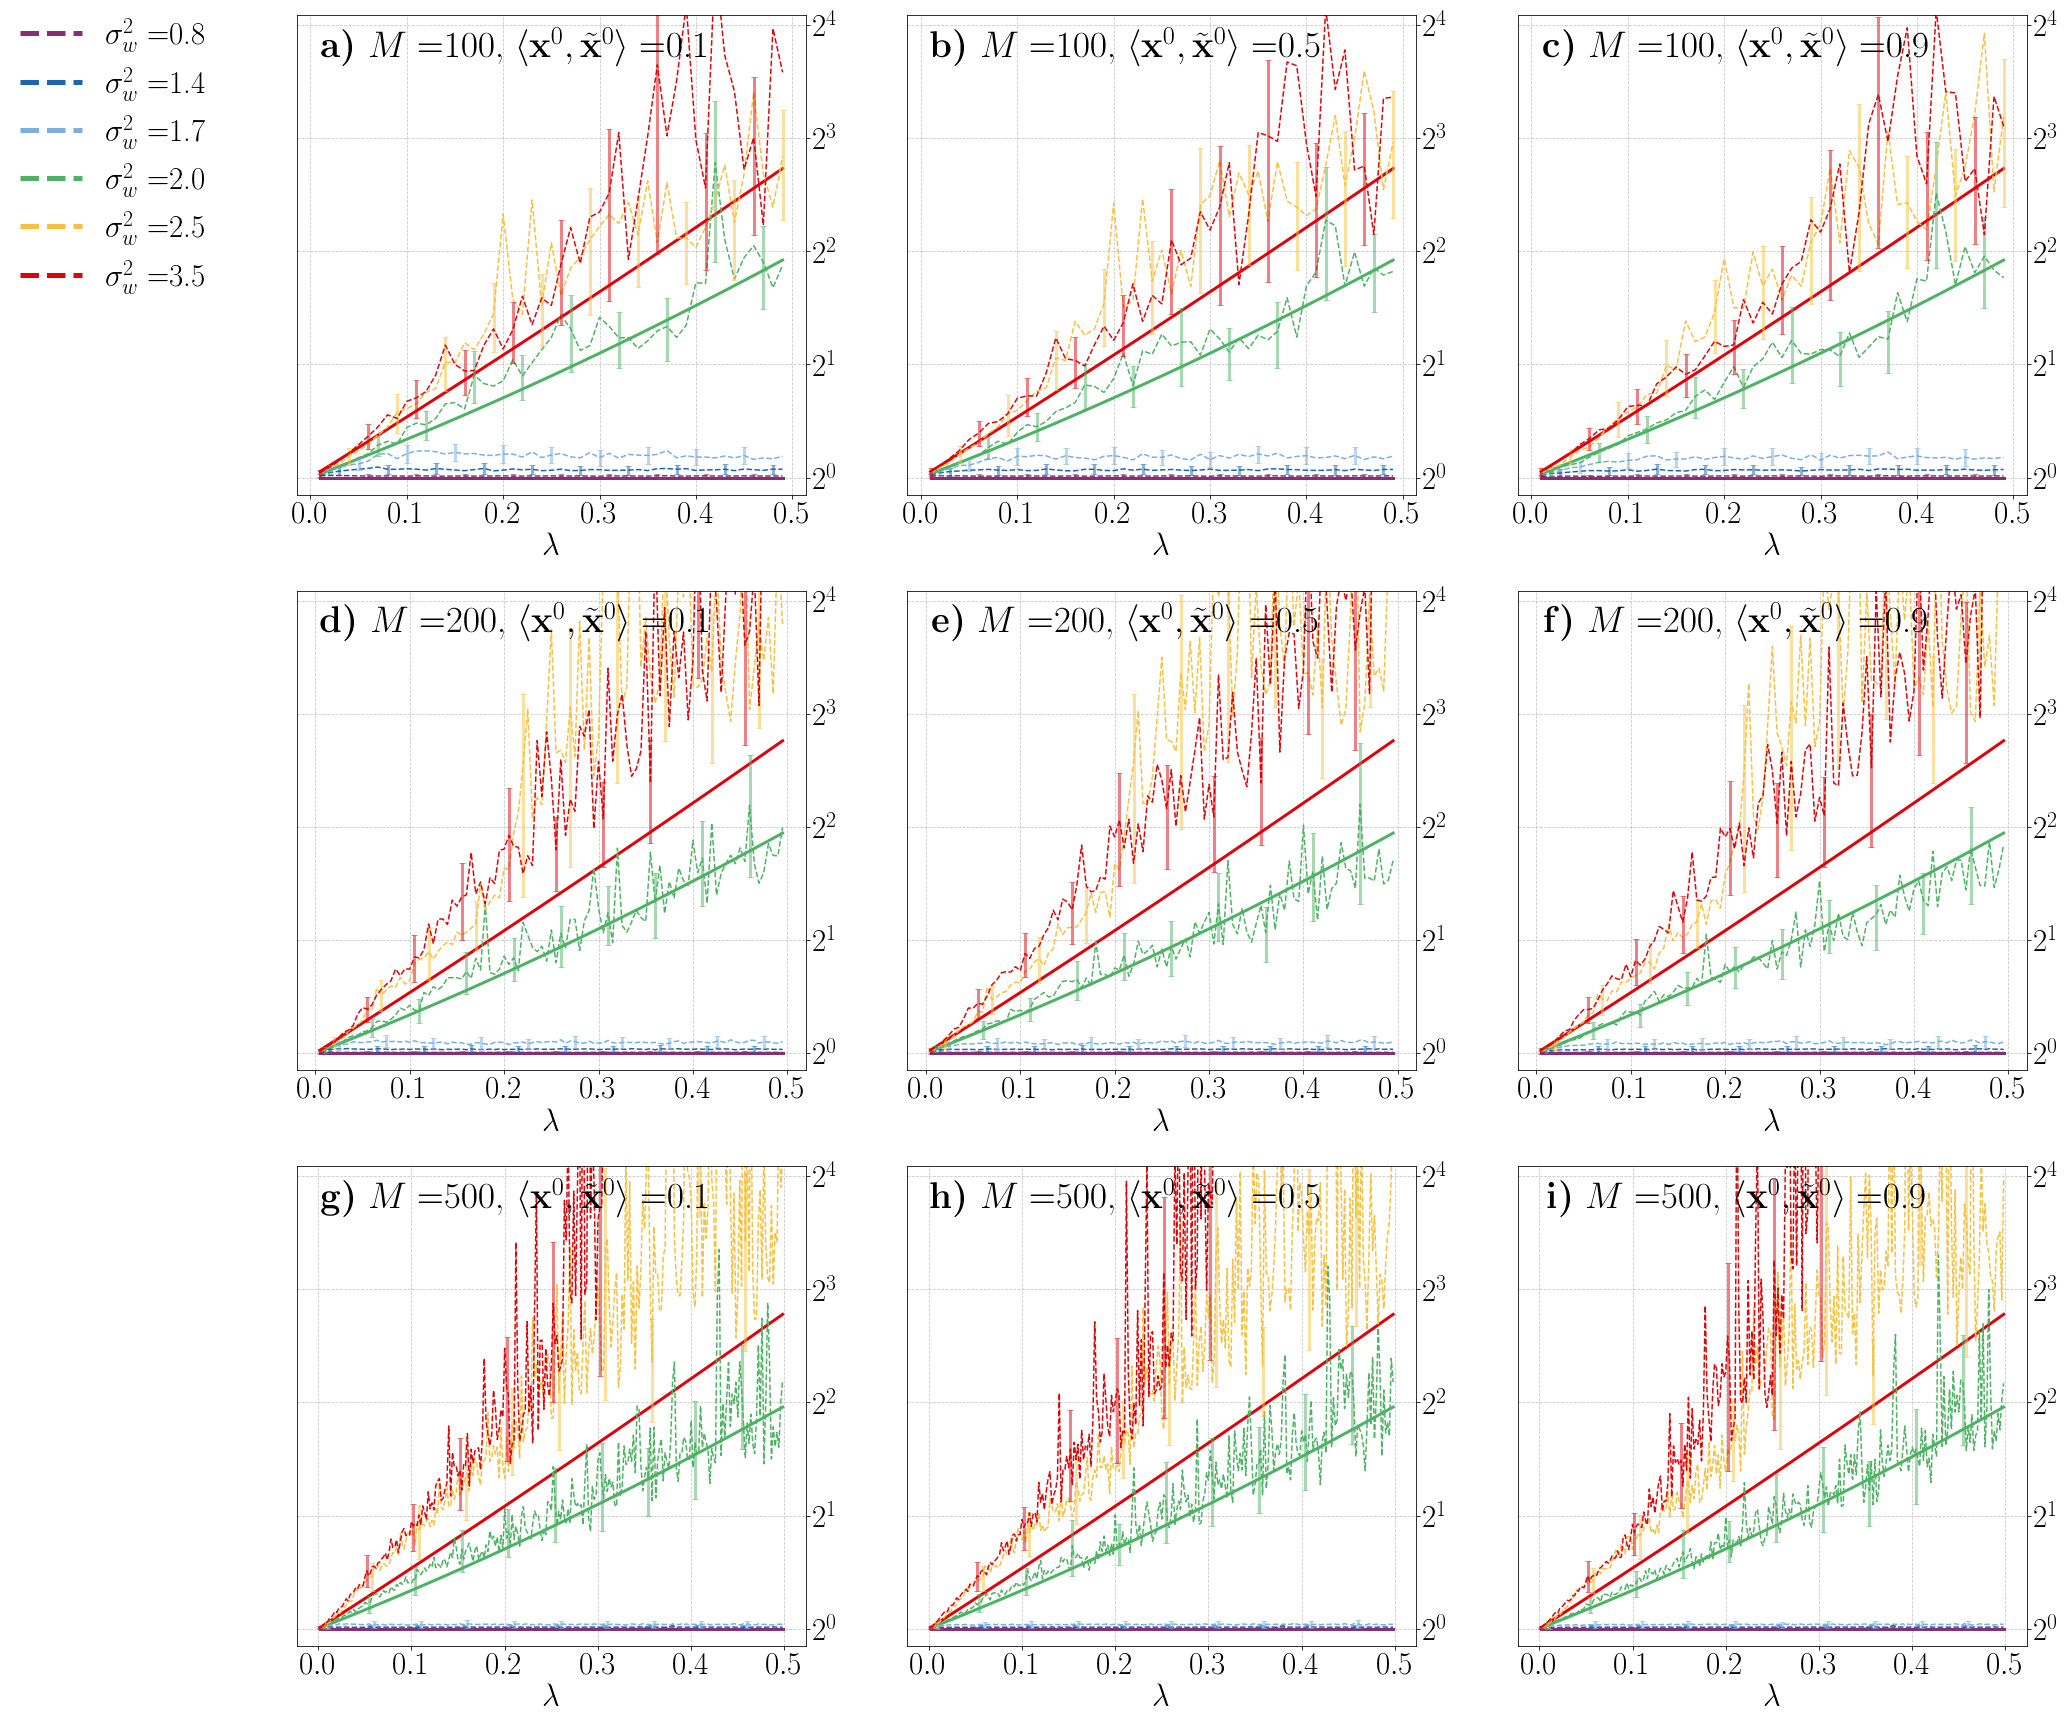

In [128]:
fig, axs = plt.subplots(3,3, figsize=(31,30))

Ms = [100, 200, 500]
a0 = 1.

corrs = [0.1,0.5,0.9]

colors = np.array(['#882e72','#1965b0','#7bafde','#4eb265','#f6c141','#dc050c'])
var_w_s = np.array([0.8,1.4,1.7,2.0,2.5,3.5])
subfig_names = [['a','b','c'],['d','e','f'],['g','h','i']]

for ax_row, M, subfig_row in zip(axs,Ms,subfig_names):
    
    
    L = int(M/2)
    n0 = int(a0*M)
    
    for ax, corr, subfig in zip(ax_row,corrs,subfig_row):
        
        l = np.array(range(1,L))/M
    
        ax.plot(l,[1]*len(l),color=colors[0],linewidth=3)

        eoc = eoc_dispersion(l,a0)
        ax.plot(l,eoc,color=colors[np.argwhere(var_w_s==2.0)].item(),linewidth=3)

        chaotic = chaotic_dispersion(l)
        ax.plot(l,chaotic,color=colors[-1],linewidth=3)


        for j,(var_w,color) in enumerate(zip(var_w_s,colors)):

            K_xy = pickle.load(open(path+'K_xy_w'+str(int(var_w*10))+'M'+str(M)+'n'+str(n0), 'rb') )
            
            nans = np.vstack((np.argwhere(np.isnan(K_xy)),np.argwhere(np.isinf(K_xy))))

            if nans.size != 0:   
                max_layer = nans[:,0].min()
                K_xy = K_xy[:max_layer,:,:]
                l = l[:max_layer]
            
            
            r_mean = unbiased_dispersion(K_xy,corr=corr)
            r_std = bootstrap_var(K_xy,corr=corr)

            ax.plot(l,r_mean, ls='--', label="$\sigma_w^2= $"+str(var_w), color=color)
            ax.errorbar(x = l, y = r_mean, yerr=r_std, fmt='None', color=color,
                     ecolor=color, elinewidth=3, capsize=3, errorevery=((2*j)%5,5*int(M/100)), alpha=0.5)


        ax.set_yscale('log',base=2)
        ax.set_ylim([0.9,17])
        ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5])
        ax.tick_params(axis='y', which='both', labelleft=False, labelright=True, left=False, right=True)  

        ax.set_xlabel('$\lambda$')
        ax.set_title(r"\textbf{"+subfig +")} $M =$"+str(M)+", $\langle \mathbf{x}^0, \\tilde{\mathbf{x}}^0 \\rangle =$"+str(corr), y=0.9, x=0.43)

        ax.grid(alpha=0.7,ls='--')
    
    
leg = axs[0,0].legend(bbox_to_anchor=(-0.6,1.05), loc='upper left', ncol=1, frameon=False) 

for line in leg.get_lines():
    line.set_linewidth(5)

## Figure 7: Dispersion of the non-diagonal NTK elements near EOC

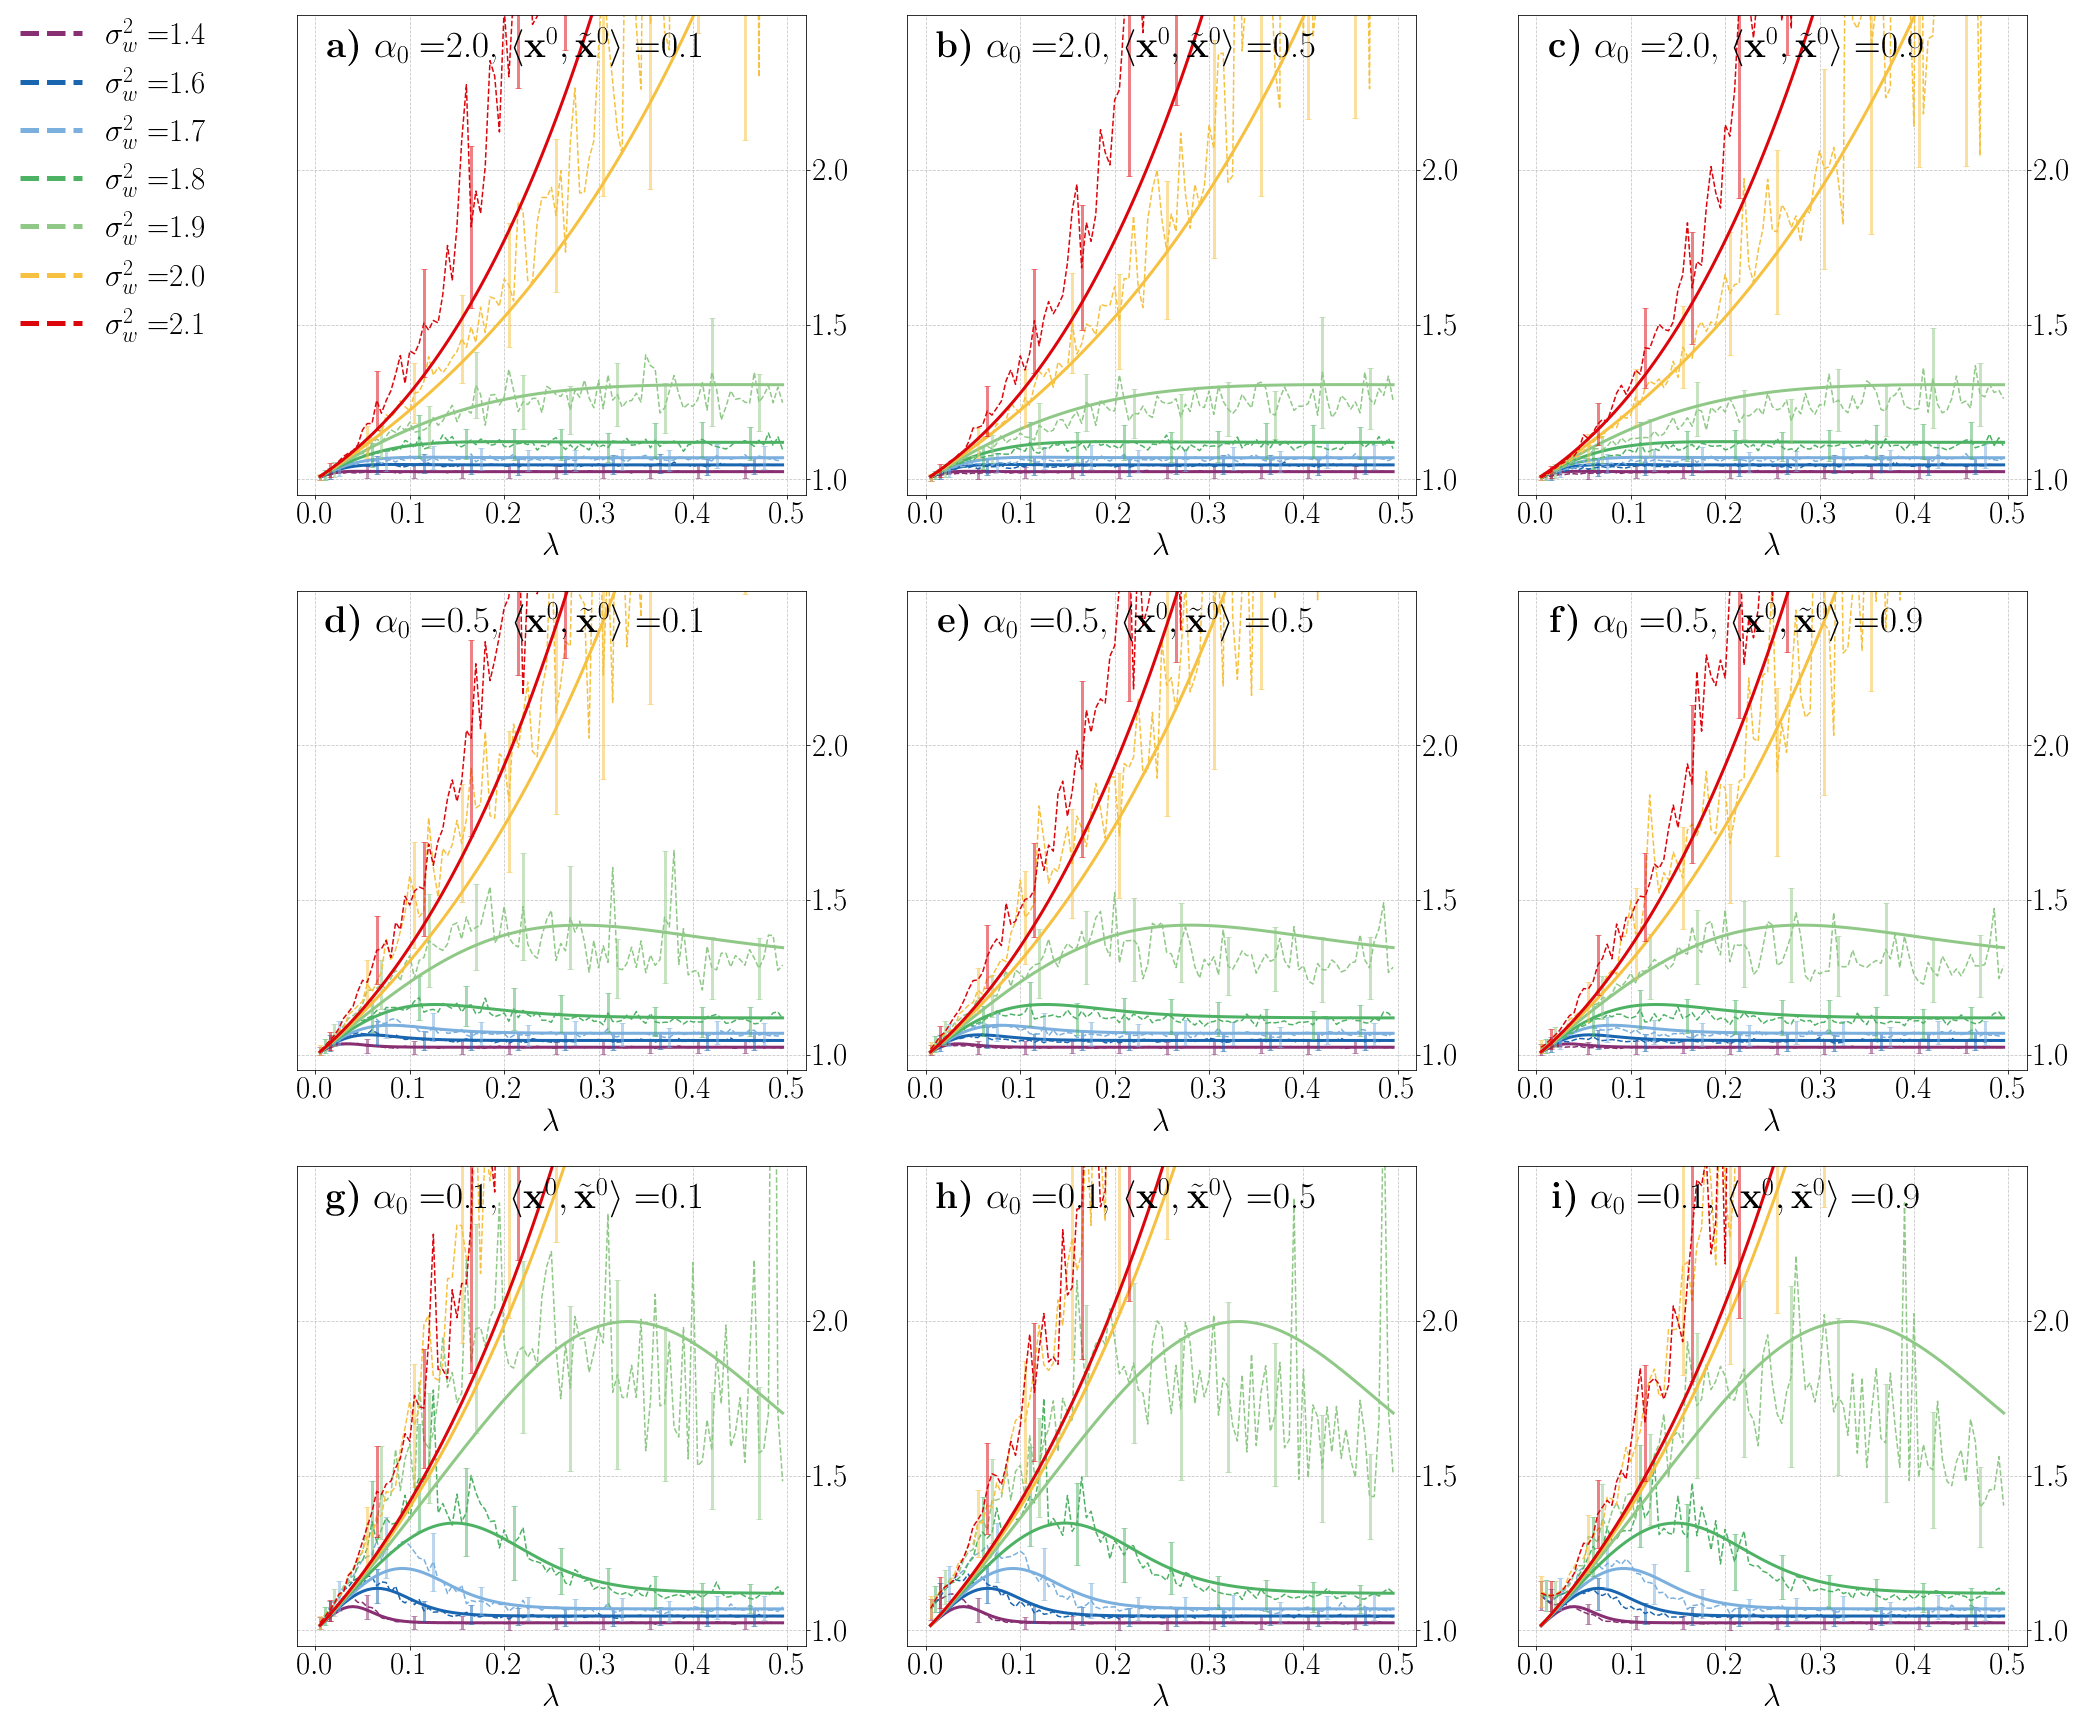

In [130]:
fig, axs = plt.subplots(3,3, figsize=(31,30))

M = 200
a0s = [2.0,0.5,0.1]

corrs = [0.1,0.5,0.9]

colors = np.array(['#882e72','#1965b0','#7bafde','#4eb265','#90c987','#f6c141','#dc050c'])
var_w_s = np.array([1.4,1.6,1.7,1.8,1.9,2.0,2.1])
subfig_names = [['a','b','c'],['d','e','f'],['g','h','i']]

for ax_row, a0, subfig_row in zip(axs,a0s,subfig_names):
    
    
    L = int(M/2)
    n0 = int(a0*M)
    
    for ax, corr, subfig in zip(ax_row,corrs,subfig_row):
        
        l = np.array(range(1,L))/M


        for j,(var_w,color) in enumerate(zip(var_w_s,colors)):

            K_xy = pickle.load(open(path+'K_xy_w'+str(int(var_w*10))+'M'+str(M)+'n'+str(n0), 'rb') )
            
            nans = np.vstack((np.argwhere(np.isnan(K_xy)),np.argwhere(np.isinf(K_xy))))

            if nans.size != 0:   
                max_layer = nans[:,0].min()
                K_xy = K_xy[:max_layer,:,:]
                l = l[:max_layer]
            
            
            r_mean = unbiased_dispersion(K_xy,corr=corr)
            r_std = bootstrap_var(K_xy,corr=corr)

            ax.plot(l,r_mean, ls='--', label="$\sigma_w^2= $"+str(var_w), color=color)
            ax.errorbar(x = l, y = r_mean, yerr=r_std, fmt='None', color=color,
                     ecolor=color, elinewidth=3, capsize=3, errorevery=((2*j)%5,5*int(M/100)), alpha=0.5)
            
            a=var_w/2.
            theory = [E_t2(a,np.array([n0]+ i*[M] + [1]))/E_t(a,np.array([n0]+ i*[M] + [1]))**2 
                for i in range(1,L)]
    
            ax.plot(l,theory, linewidth=3, color=color)

        ax.set_ylim([0.95,2.5])
        ax.set_yticks([1,1.5,2.0])
        ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5])
        ax.tick_params(axis='y', which='both', labelleft=False, labelright=True, left=False, right=True)   
       
        ax.set_xlabel('$\lambda$')
        ax.set_title(r"\textbf{"+subfig +")} $\\alpha_0 =$"+str(a0)+", $\langle \mathbf{x}^0, \\tilde{\mathbf{x}}^0 \\rangle =$"+str(corr), y=0.9, x=0.43)

        ax.grid(alpha=0.7,ls='--')
    
    
leg = axs[0,0].legend(bbox_to_anchor=(-0.6,1.05), loc='upper left', ncol=1, frameon=False) 

for line in leg.get_lines():
    line.set_linewidth(5)

# Appendix: Error bars

### Figure 8: Continous error bars for the NTK dispersion in the infinite-depth-and-width limit

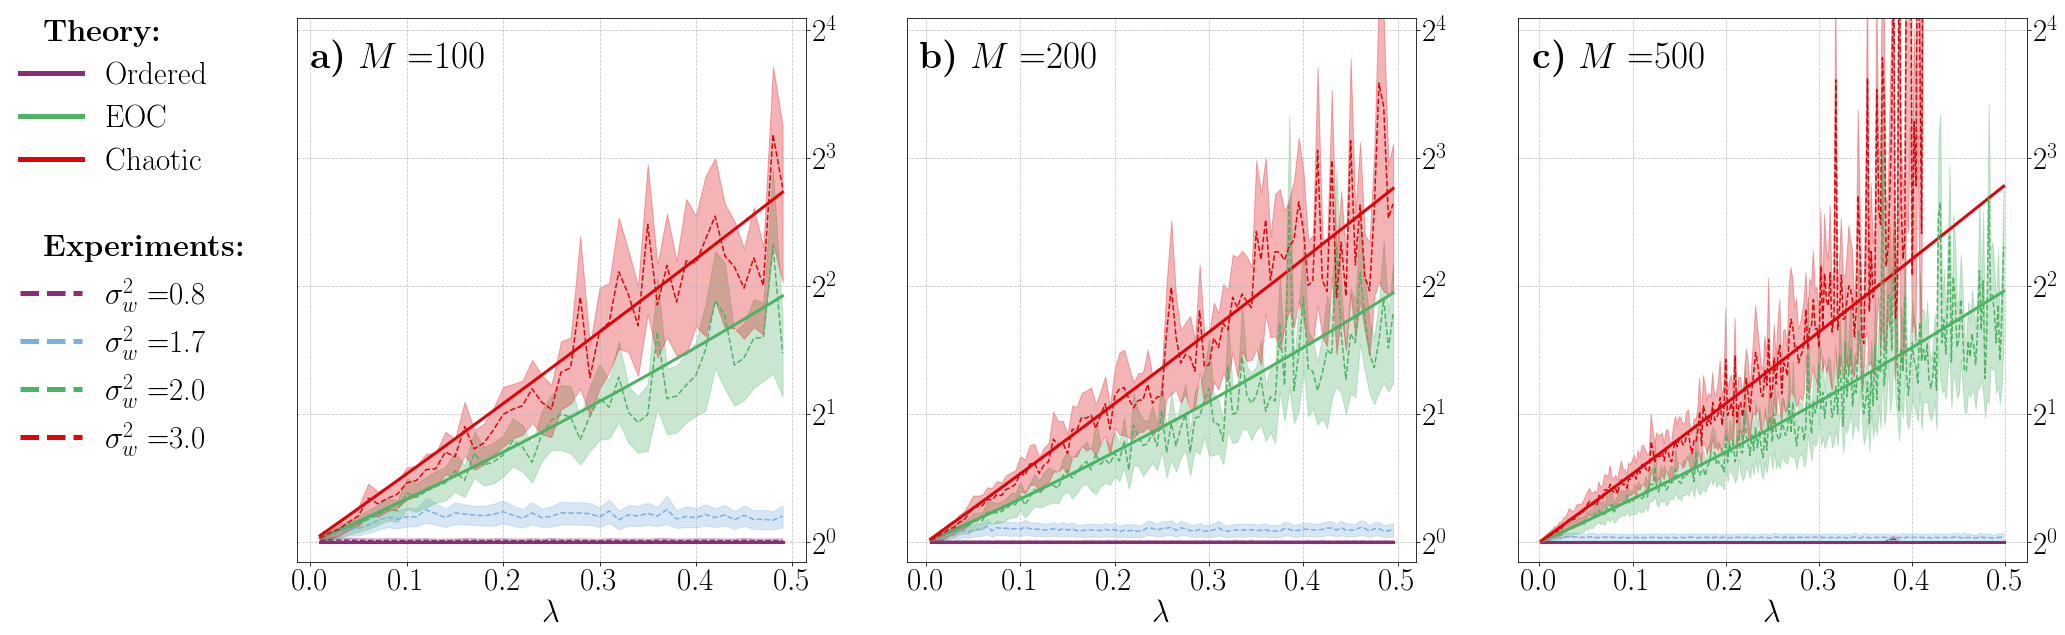

In [4]:
fig, axs = plt.subplots(1,3, figsize=(31,10))

Ms = [100, 200, 500]
a0 = 1.

corr = 0

colors = np.array(['#882e72','#7bafde','#4eb265','#dc050c'])
var_w_s = np.array([0.8,1.7,2.0,3.0])
subfig_names = ['a','b','c']

for ax, M, subfig in zip(axs,Ms,subfig_names):
    
    L = int(M/2)
    n0 = int(a0*M)
    l = np.array(range(1,L))/M
    
    ax.plot(l,[1]*len(l),color=colors[0],linewidth=3, label='Ordered')

    eoc = eoc_dispersion(l,a0)
    ax.plot(l,eoc,color=colors[np.argwhere(var_w_s==2.0)].item(),linewidth=3,label='EOC')

    chaotic = chaotic_dispersion(l)
    ax.plot(l,chaotic,color=colors[-1],linewidth=3, label='Chaotic')


    for j,(var_w,color) in enumerate(zip(var_w_s,colors)):

        K_xy = pickle.load(open(path+'K_xy_w'+str(int(var_w*10))+'M'+str(M)+'n'+str(n0), 'rb') )
        
        nans = np.vstack((np.argwhere(np.isnan(K_xy)),np.argwhere(np.isinf(K_xy))))
    
        if nans.size != 0:   
            max_layer = nans[:,0].min()
            K_xy = K_xy[:max_layer,:,:]
            l = l[:max_layer]
    
        r_mean = unbiased_dispersion(K_xy)
        r_std = bootstrap_var(K_xy)

        ax.plot(l,r_mean, ls='--', label="$\sigma_w^2= $"+str(var_w), color=color)
        ax.fill_between(x=l, y1=r_mean-r_std, y2=r_mean+r_std, color=color, alpha=0.3)
        
  
    
    ax.set_yscale('log',base=2)
    ax.set_ylim([0.9,17])
    ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5])
    ax.tick_params(axis='y', which='both', labelleft=False, labelright=True, left=False, right=True)  

    ax.set_xlabel('$\lambda$')
    ax.set_title("$\ \\textbf{"+subfig+")}"+"\\alpha = \ $"+str(a0), y=0.9, x=0.18)

    ax.grid(alpha=0.7,ls='--')
    
    
(lines, labels) = axs[0].get_legend_handles_labels()
lines.insert(0,plt.Line2D([0],[0], linestyle='None', marker='None'))
labels.insert(0, r'\textbf{Theory:}')

ind_exp_legend = -len(var_w_s)
lines.insert(ind_exp_legend,plt.Line2D([0],[0], linestyle='None', marker='None'))
labels.insert(ind_exp_legend, '')
lines.insert(ind_exp_legend,plt.Line2D([0],[0], linestyle='None', marker='None'))
labels.insert(ind_exp_legend, r'\textbf{Experiments:}')
    
leg = axs[0].legend(lines,labels, bbox_to_anchor=(-0.6,1.05), loc='upper left', ncol=1, frameon=False) 

for line in leg.get_lines():
    line.set_linewidth(5)

for vpack in leg._legend_handle_box.get_children()[:1]:
    hs = vpack.get_children()[:1] + vpack.get_children()[ind_exp_legend-1:ind_exp_legend]
    for hpack in hs:
        hpack.get_children()[0].set_width(0)


### Figure 9: Continous error bars for the NTK dispersion around the EOC

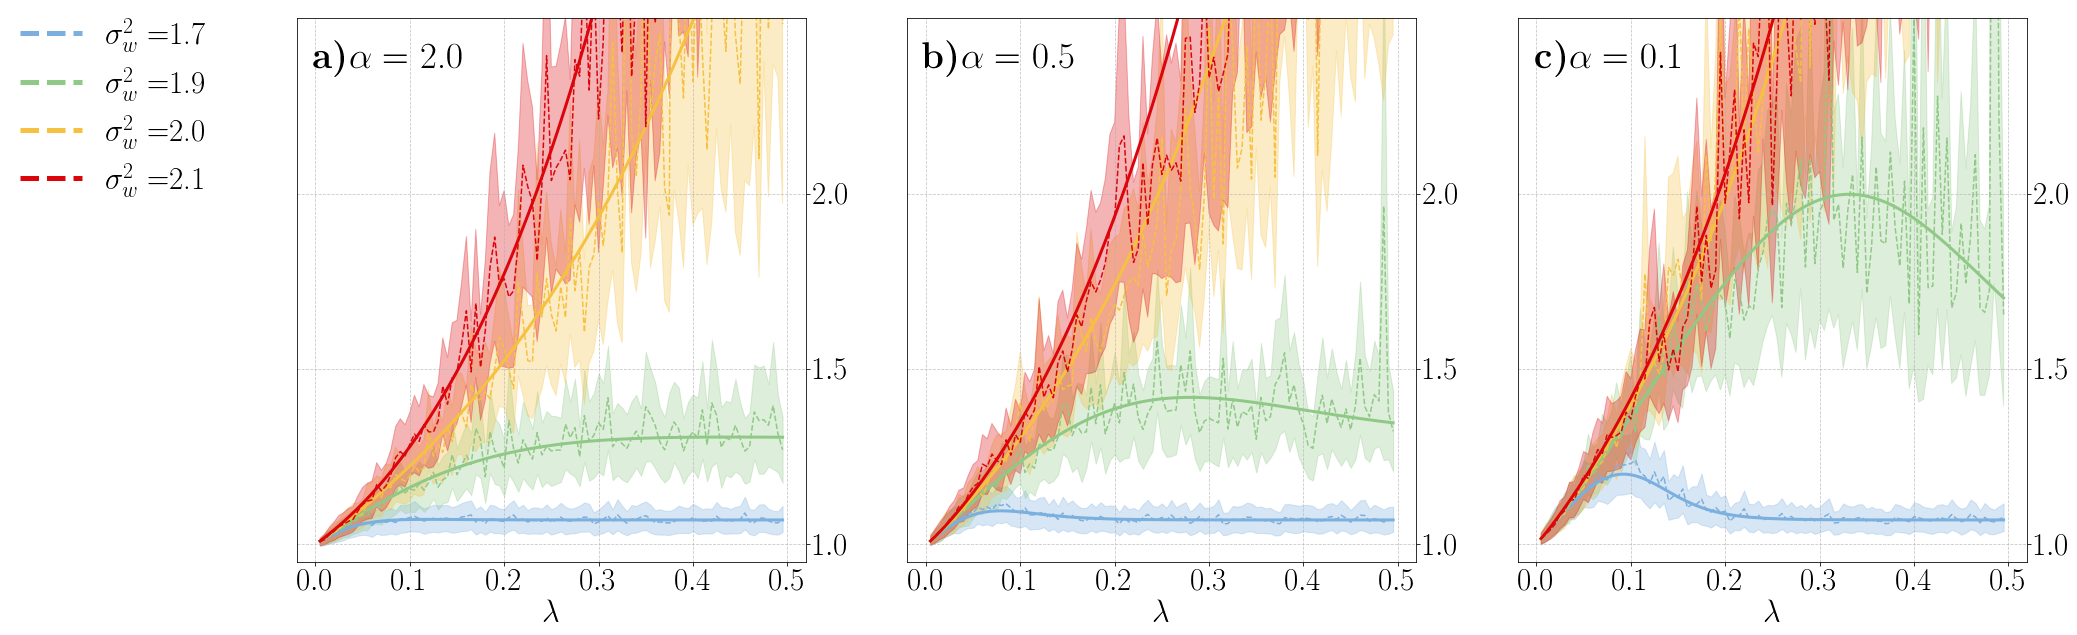

In [39]:
fig, axs = plt.subplots(1,3, figsize=(31,10))

M = 200
a0s = [2.0,0.5,0.1]

corr = 0

L_max = int(M/2)

colors = np.array(['#7bafde','#90c987','#f6c141','#dc050c'])
var_w_s = np.array([1.7,1.9,2.0,2.1])
subfig_names = ['a','b','c']

for ax, a0, subfig in zip(axs,a0s,subfig_names):
    
    L = int(M/2)
    n0 = int(a0*M)
    l = np.array(range(1,L))/M
    
    
    for j,(var_w,color) in enumerate(zip(var_w_s,colors)):
        
        a=var_w/2.
        theory = [E_t2(a,np.array([n0]+ i*[M] + [1]))/E_t(a,np.array([n0]+ i*[M] + [1]))**2 
                for i in range(1,L)]
    
        ax.plot(l,theory, linewidth=3, color=color)
        
        K_xy = pickle.load(open(path+'K_xy_w'+str(int(var_w*10))+'M'+str(M)+'n'+str(n0), 'rb') )
        
        nans = np.vstack((np.argwhere(np.isnan(K_xy)),np.argwhere(np.isinf(K_xy))))
    
        if nans.size != 0:   
            max_layer = nans[:,0].min()
            K_xy = K_xy[:max_layer,:,:]
            l = l[:max_layer]
    
        r_mean = unbiased_dispersion(K_xy)
        r_std = bootstrap_var(K_xy)

        ax.plot(l,r_mean, ls='--', label="$\sigma_w^2= $"+str(var_w), color=color)
        ax.fill_between(x=l, y1=r_mean-r_std, y2=r_mean+r_std, color=color, alpha=0.3)

    
    ax.set_ylim([0.95,2.5])
    ax.set_yticks([1,1.5,2.0])
    ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5])
    ax.tick_params(axis='y', which='both', labelleft=False, labelright=True, left=False, right=True)   

    ax.set_xlabel('$\lambda$')
    ax.set_title("$\ \\textbf{"+subfig+")}"+"\\alpha = \ $"+str(a0), y=0.9, x=0.18)

    ax.grid(alpha=0.7,ls='--')
    
    
leg = axs[0].legend(bbox_to_anchor=(-0.6,1.05), loc='upper left', ncol=1, frameon=False) 

for line in leg.get_lines():
    line.set_linewidth(5)

### Figure 10: Error bars for the ration of non-diagonal and diagonal elements of the NTK

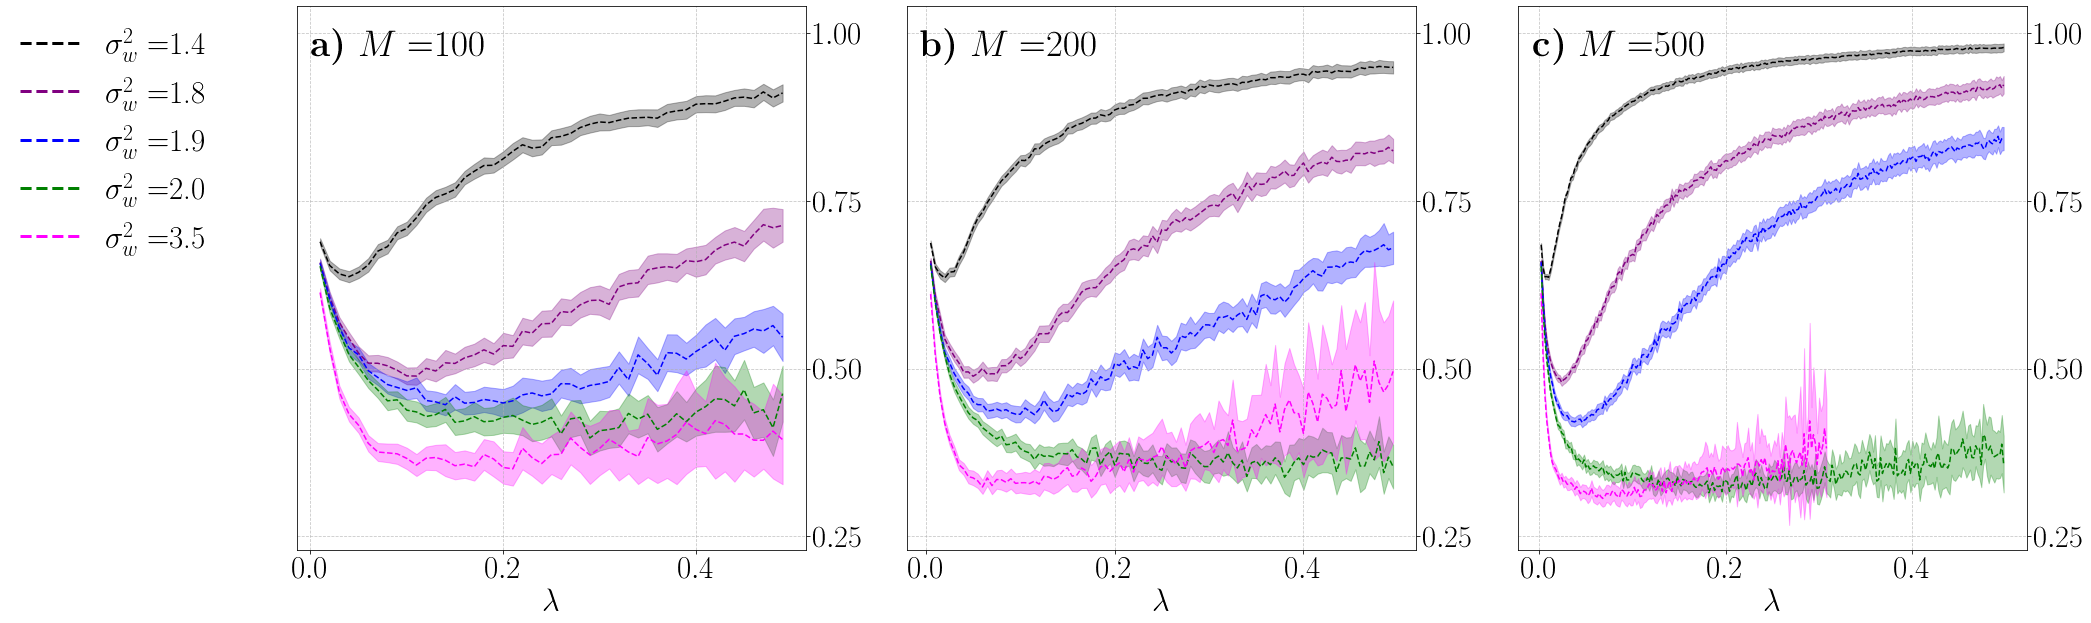

In [143]:
fig, axs = plt.subplots(1,3,figsize=(31,10))

Ms = [100,200,500]
var_w_s = [1.4,1.8,1.9,2.0,3.5]
cmaps = ["Greys","Purples","Blues","Greens","PuRd"]
colors = ['black', 'purple', 'blue', 'green', 'magenta']
markers = ['^',"D",'P','o','d']

subfig_names = ['a','b','c']

r0 = 0.5

BS_it = 1000

for M,ax,subfig in zip(Ms,axs,subfig_names):

    L = int(M/2)
    n0 = M

    for j,(var_w,color,m) in enumerate(zip(var_w_s,colors,markers)):
       
        K_xy = pickle.load(open(path+'K_xy_w'+str(int(var_w*10))+'M'+str(M)+'n'+str(n0), 'rb') )
        l = np.array(range(1,L))/M
        MC_it = K_xy.shape[1]

        nans = np.vstack((np.argwhere(np.isnan(K_xy)),np.argwhere(np.isinf(K_xy))))
        
        if nans.size != 0:   
            max_layer = nans[:,0].min()
            K_xy = K_xy[:max_layer,:,:]
            l = l[:max_layer]
            
        K_xy = K_xy/K_xy.max()
        
        MC_it = K_xy.shape[1]
        mc_ind = list(range(MC_it))

        K = K_xy/K_xy.max(axis=1)[:,None,:]

        r_samples = []

        for i in range(BS_it):

            sum_k = []

            ind_bs_1 = np.random.choice(mc_ind, MC_it, replace = True)
            ind_bs_2 = np.random.choice(mc_ind, MC_it, replace = True)

            diag = np.mean(K_xy[:,ind_bs_1,0],axis=1)
            non_diag = np.mean(K_xy[:,ind_bs_2,round((1-r0)*10)],axis=1)
            r_samples.append(non_diag/diag)

        
        r_mean = np.mean(r_samples, axis=0)
        
        r_std = np.std(r_samples,axis=0)

        ax.plot(l,r_mean, ls='--', label="$\sigma_w^2= $"+str(var_w), color=color)
        ax.fill_between(x=l, y1=r_mean-r_std, y2=r_mean+r_std, color=color, alpha=0.3)
        
        
        ax.grid(alpha=0.7,ls='--')
        ax.set_ylim([0.23,1.04])
        ax.set_xlabel('$\lambda$')
        
        ax.set_yticks([0.25,0.5,0.75,1.])
        ax.yaxis.tick_right()
        
        ax.set_title(r"$\textbf{"+subfig+")}\ M =$"+str(M), y=0.9, x=0.2)
        

leg = axs[0].legend(bbox_to_anchor=(-0.6,1.01), 
                   loc='upper left', ncol=1, frameon=False, markerscale=1.5) 
leg.get_frame().set_alpha(0.5)

for line in leg.get_lines():
    line.set_linewidth(3) 